In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import optax
from functools import partial
from typing import Callable
import time

from history import History

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from cmap import Colormap
cmap = Colormap('crameri:batlow').to_mpl()

In [2]:
from problems import Poisson3D
problem = Poisson3D()

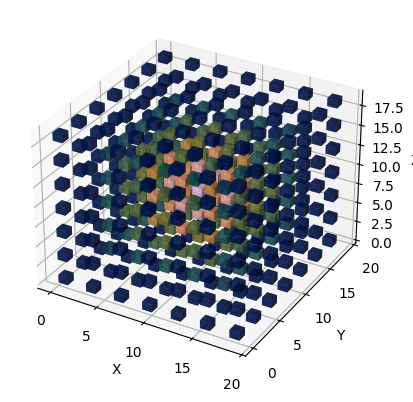

In [3]:
X, Y, Z, u_solution = problem.exact_solution(nx=7, ny=7, nz=7)

def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = u_solution.shape[0]
y_num = u_solution.shape[1]
z_num = u_solution.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(u_solution)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [4]:
X, Y, Z, u_solution = problem.exact_solution(nx=32, ny=32, nz=32)

# Optimiser

In [20]:
class GNNG:
    """
    Levenberg-Marquardt optimiser.
    """

    def __init__(
        self,
        learning_rate: float = 0.1,
        damping: float = 0.1,
    ):
            self.learning_rate = learning_rate
            self.damping = damping

    def init(self, params: eqx.Module):
        """Initializes the optimizer state with the initial damping factor."""
        return {
        }

    def update(
        self,
        params: eqx.Module,
        state: optax.OptState, # The state is unused in this simple version
        residual_fn: Callable[[eqx.Module], jax.Array]
    ):
        """
        Performs a single GNNG optimisation step.

        Args:
            params: A PyTree of the model parameters.
            state: The optimiser state (unused).
            residual_fn: A function that takes the parameters and returns
                         the residual vector.

        Returns:
            A tuple containing (current_loss, updates, new_state, metrics).
        """
        params_flat, unflatten = jax.flatten_util.ravel_pytree(params)

        def flat_residual_fn(p_flat):
            return residual_fn(unflatten(p_flat))

        residuals = residual_fn(params)
        J = jax.jacfwd(flat_residual_fn)(params_flat)
        
        g_matrix = J.T @ J
        
        grad_L = J.T @ residuals

        num_params = params_flat.shape[0]
        identity = jnp.eye(num_params)
        g_matrix_damped = g_matrix + 1e5 * identity

        search_direction = jnp.linalg.solve(g_matrix_damped, -grad_L)
        
        delta = self.learning_rate * search_direction
        updates = unflatten(delta)
        
        current_loss = jnp.mean(residuals**2)
        new_state = {}  # No state to update
        metrics = {
            'loss': current_loss,
            'update_norm': jnp.linalg.norm(delta),
            'gradient_norm': jnp.linalg.norm(grad_L),
        }

        return current_loss, updates, new_state, metrics    
    
@partial(jax.jit, static_argnums=(3, 4))
def train_step(params, static_parts, opt_state, optimiser, problem, collocation_points):
    def residual_fn_for_optimizer(p):
        rebuilt_model = eqx.combine(p, static_parts)
        return problem.physics_residual(problem.residual_fn, rebuilt_model, collocation_points)

    loss, updates, new_opt_state, metrics = optimiser.update(params, opt_state, residual_fn_for_optimizer)
    new_params = eqx.apply_updates(params, updates)
    
    return new_params, new_opt_state, loss, metrics

In [21]:
key = jax.random.PRNGKey(42)

# --- Hyperparameters ---
n_collocation_points = 2**12
layer_sizes = [3, 16, 16, 16, 16, 1]
# -----------------------

model_key, data_key = jax.random.split(key)
model = problem.FCN(model_key, layer_sizes)
params, static = eqx.partition(model, eqx.is_array)
history = History()
collocation_points = problem.get_collocation_points(n_collocation_points, seed=1)

optimiser = GNNG(
    learning_rate=1.0,
    damping=1e-2,
)
opt_state = optimiser.init(params)

start_time = time.monotonic()

epoch = 0
for _ in range(500):
    epoch += 1
    
    params, opt_state, loss_val, metrics = train_step(
        params, static, opt_state, optimiser, problem, collocation_points
    )
    history.record(metrics)
    elapsed_seconds = time.monotonic() - start_time

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}, Loss: {loss_val.item():.3e}, Time elapsed: {elapsed_seconds:.2f} s")

model = eqx.combine(params, static)
print("Training complete.")

Epoch 5, Loss: 1.052e+02, Time elapsed: 8.34 s
Epoch 10, Loss: 9.977e+01, Time elapsed: 11.72 s
Epoch 15, Loss: 9.386e+01, Time elapsed: 14.54 s
Epoch 20, Loss: 9.280e+01, Time elapsed: 17.82 s
Epoch 25, Loss: 9.101e+01, Time elapsed: 20.93 s
Epoch 30, Loss: 8.621e+01, Time elapsed: 24.36 s
Epoch 35, Loss: 7.802e+01, Time elapsed: 27.21 s
Epoch 40, Loss: 7.043e+01, Time elapsed: 30.25 s
Epoch 45, Loss: 6.057e+01, Time elapsed: 33.18 s
Epoch 50, Loss: 5.117e+01, Time elapsed: 36.07 s
Epoch 55, Loss: 4.535e+01, Time elapsed: 39.21 s
Epoch 60, Loss: 4.071e+01, Time elapsed: 42.13 s
Epoch 65, Loss: 3.656e+01, Time elapsed: 44.91 s
Epoch 70, Loss: 3.131e+01, Time elapsed: 48.10 s
Epoch 75, Loss: 2.398e+01, Time elapsed: 51.15 s
Epoch 80, Loss: 1.624e+01, Time elapsed: 54.46 s
Epoch 85, Loss: 1.151e+01, Time elapsed: 57.49 s
Epoch 90, Loss: 9.027e+00, Time elapsed: 61.83 s
Epoch 95, Loss: 7.312e+00, Time elapsed: 65.96 s
Epoch 100, Loss: 5.928e+00, Time elapsed: 69.87 s
Epoch 105, Loss: 4.81

KeyboardInterrupt: 

In [14]:
u_pred = model.predict(X, Y, Z)

error = jnp.abs(u_solution - u_pred)
rel_l2_error = jnp.linalg.norm(error) / jnp.linalg.norm(u_solution)

print(f"Relative L2 Error: {rel_l2_error:.3e}")

Relative L2 Error: 6.298e-03


In [ ]:
error2 = error[::5, ::5, ::5]
print(error2.shape)

(7, 7, 7)


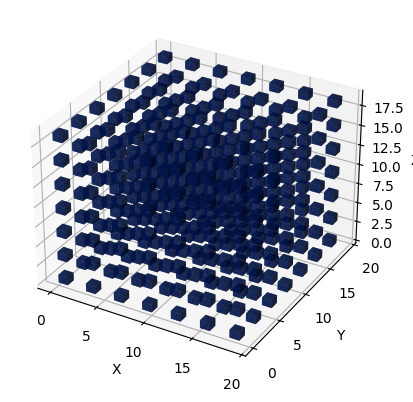

In [ ]:
def explode(data):
    size = np.array(data.shape)*3
    data_e = np.zeros(size - 1, dtype=data.dtype)
    data_e[::3, ::3, ::3] = data
    return data_e

x_num = error2.shape[0]
y_num = error2.shape[1]
z_num = error2.shape[2]
filled = np.ones((x_num, y_num, z_num), dtype=bool)
filled_2 = explode(filled)
values_2 = explode(error2)
facecolors_2 = cmap(values_2)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.voxels(filled=filled_2, facecolors=facecolors_2, alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

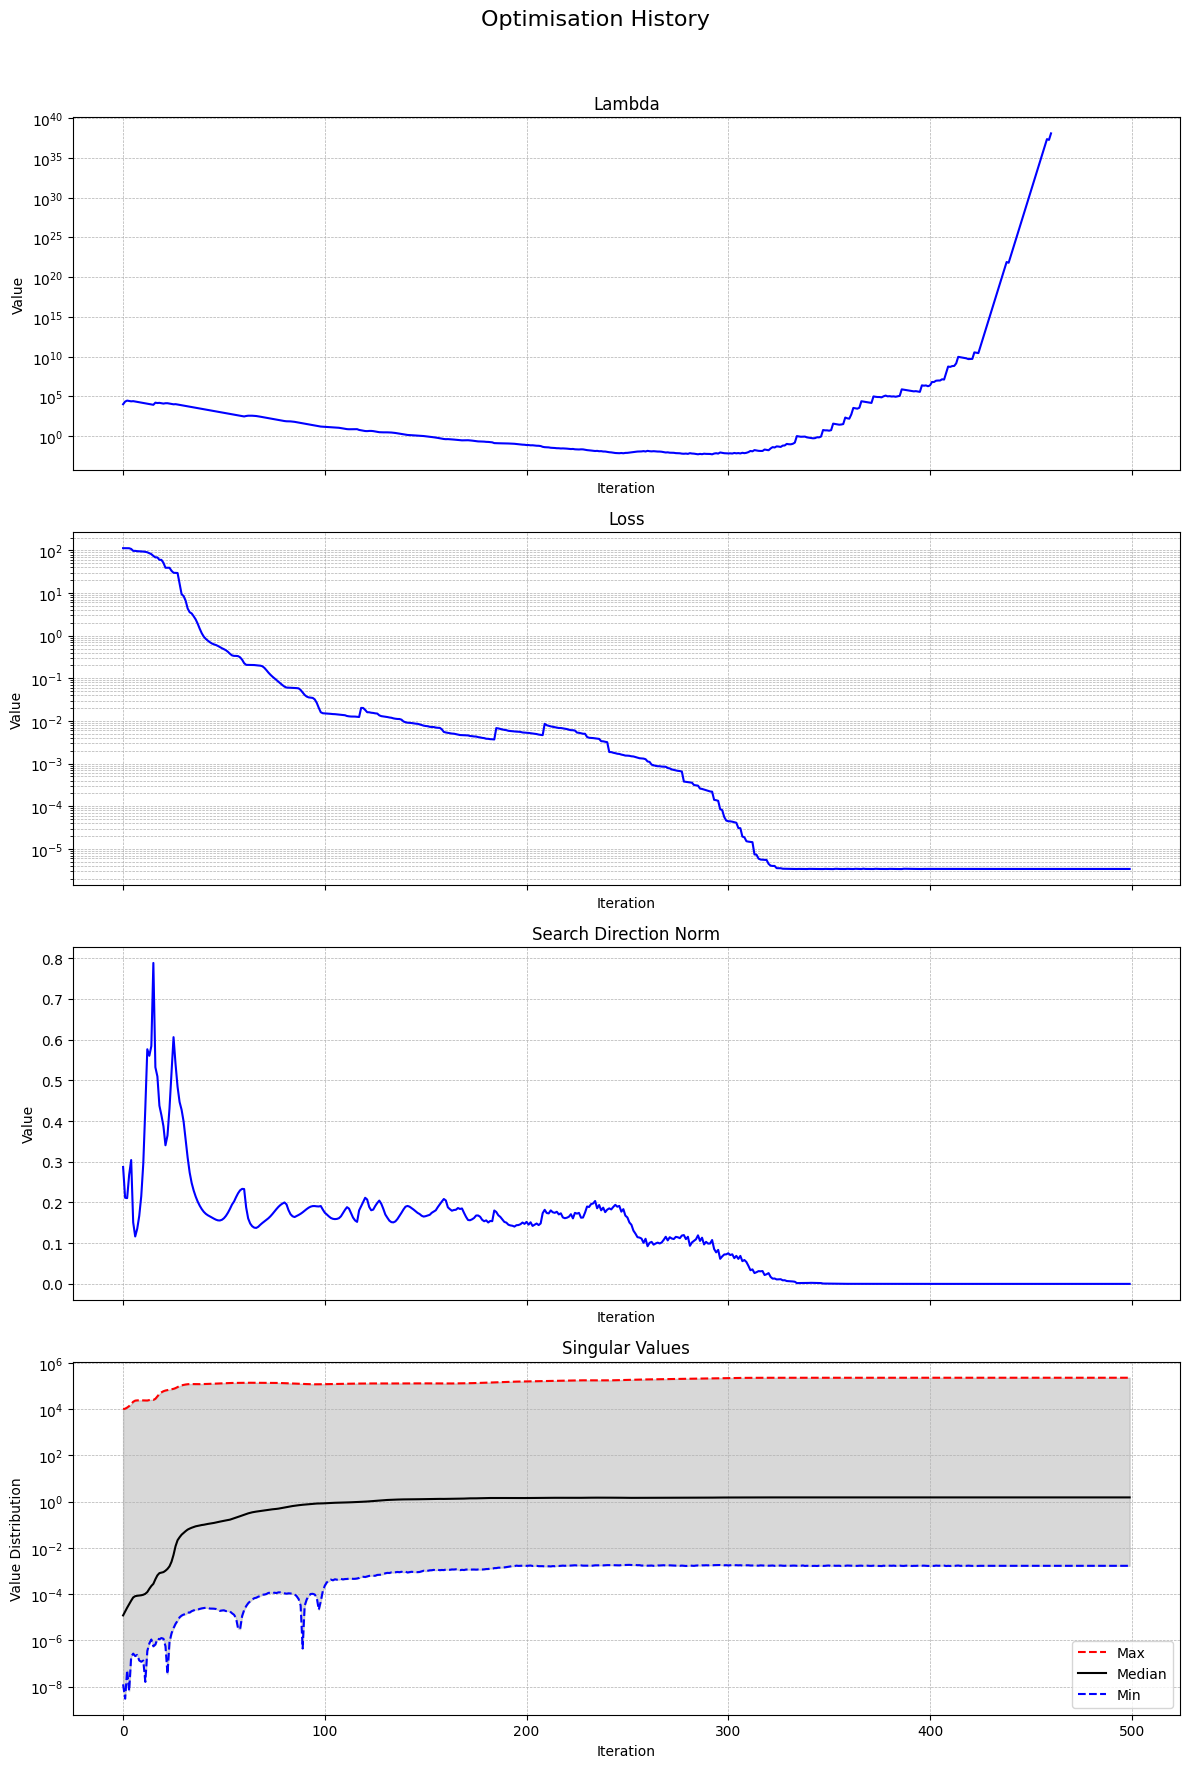

In [ ]:
history.plot()